## Image classification using CNN 

Dataset: [Kaggle Dogs vs Cats Competition Data](https://www.kaggle.com/c/dogs-vs-cats)

Objective: To design a classifier to identify Dogs and Cats

Architecture: ResNet34
![](https://msdnshared.blob.core.windows.net/media/2017/02/021717_1842_QuickStartG4.png)

Learning Rate Optimiziation: [The Cyclical Learning Rate](http://teleported.in/posts/cyclic-learning-rate/) 

References:
- [Snapshot Ensembles](https://arxiv.org/pdf/1704.00109.pdf)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
PATH = 'data/dogscats/'
sz=224

Checking if CUDA is working 

In [5]:
torch.cuda.is_available()

True

In [6]:
torch.backends.cudnn.enabled

True

In [7]:
os.listdir(PATH)

['sample', 'valid', 'models', 'train', 'tmp', 'test1']

In [8]:
os.listdir(f'{PATH}valid')

['cats', 'dogs']

In [9]:
files = os.listdir(f'{PATH}valid/cats')[:5]

In [10]:
files

['cat.11341.jpg',
 'cat.3869.jpg',
 'cat.5089.jpg',
 'cat.7380.jpg',
 'cat.11409.jpg']

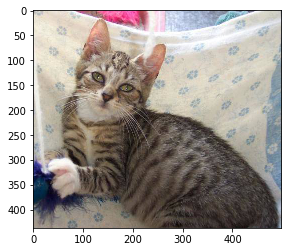

In [11]:
img = plt.imread(f'{PATH}valid/cats/{files[0]}')
plt.imshow(img)

In [12]:
img.shape

(437, 499, 3)

Quick start

In [14]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch,data, precompute=True)
learn.fit(0.00979,3)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[0.      0.05771 0.02758 0.99219]                             
[1.      0.03565 0.02669 0.98877]                             
[2.      0.03606 0.02683 0.99121]                             



In [15]:
data.val_y

array([0, 0, 0, ..., 1, 1, 1])

In [16]:
data.classes

['cats', 'dogs']

In [17]:
log_preds = learn.predict()
log_preds.shape

(2000, 2)

In [18]:
log_preds[:10]

array([[ -0.00004, -10.2325 ],
       [ -0.00245,  -6.01436],
       [ -0.0008 ,  -7.12606],
       [ -0.00023,  -8.37298],
       [ -0.00005,  -9.95216],
       [ -0.00059,  -7.43774],
       [ -0.00004, -10.11006],
       [ -0.00003, -10.55156],
       [ -0.00369,  -5.60395],
       [ -0.00013,  -8.96894]], dtype=float32)

In [19]:
preds = np.argmax(log_preds, axis=1)
probs = np.exp(log_preds[:,1])

In [20]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])
        
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

Correctly classified


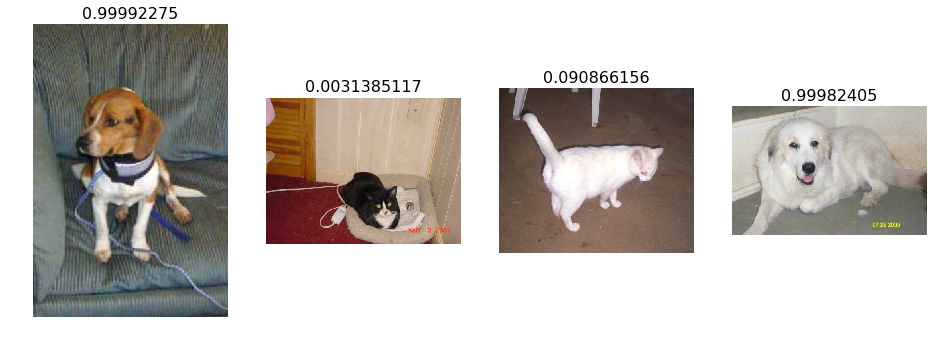

In [21]:

# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


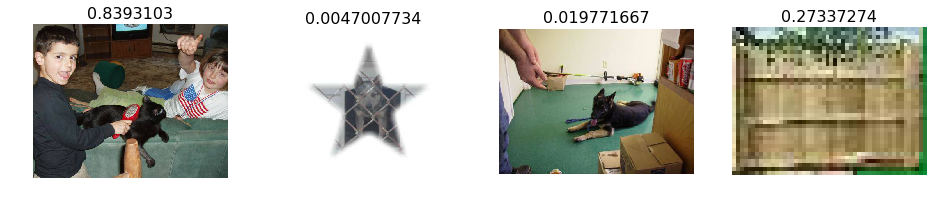

In [22]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [23]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct cats


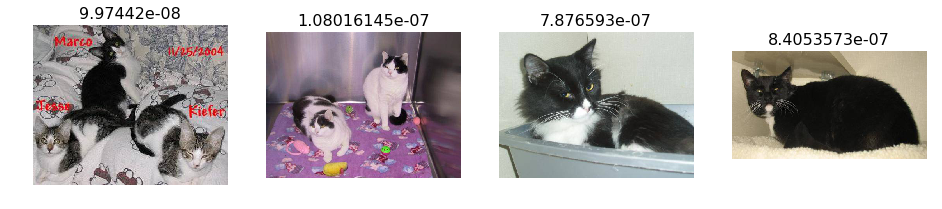

In [24]:
plot_val_with_title(most_by_correct(0, True), "Most correct cats")

Most correct dogs


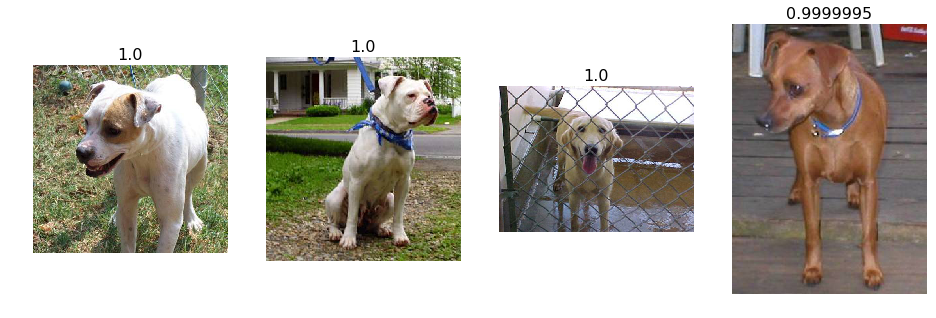

In [25]:
plot_val_with_title(most_by_correct(1, True), "Most correct dogs")

Most incorrect cats


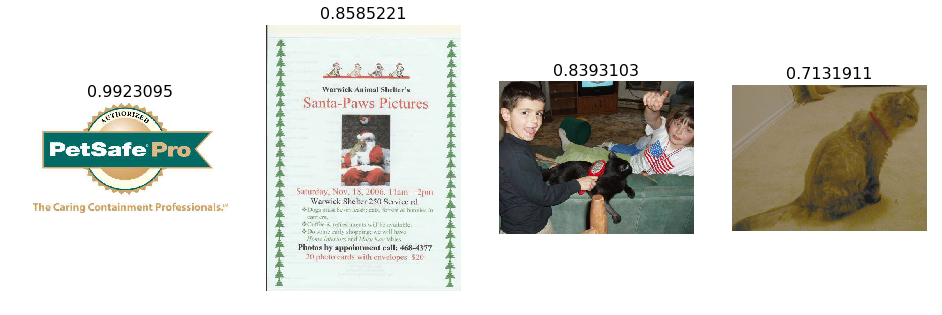

In [26]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


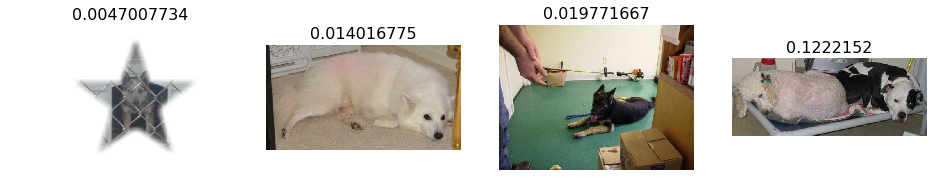

In [27]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

Most uncertain predictions


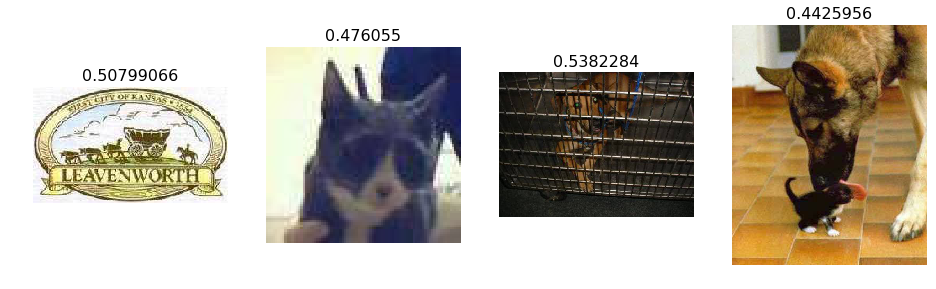

In [28]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

## Choosing a learning rate

Technique used:  Cyclical Learning Rates for Training Neural Networks

In [29]:
learn = ConvLearner.pretrained(arch,data,precompute=True)

In [30]:
lrf=learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 75%|███████▍  | 269/360 [00:04<00:01, 60.81it/s, loss=0.431]


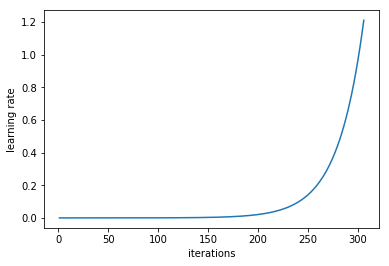

In [31]:
learn.sched.plot_lr()

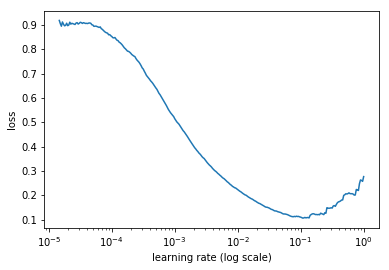

In [32]:
learn.sched.plot()

## Imrpoving the model

### Data Augmentation

In [34]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [37]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [38]:
ims = np.stack([get_augs() for i in range(6)])

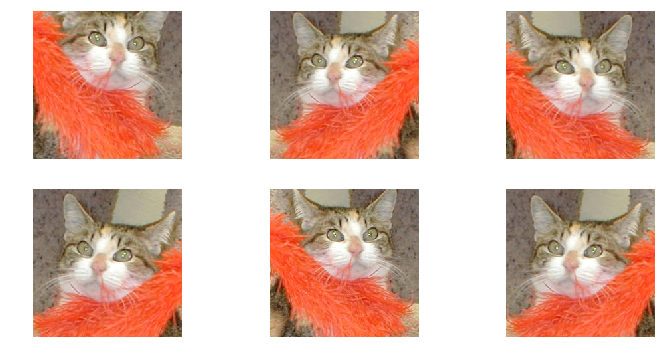

In [39]:
plots(ims, rows=2)

In [40]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [48]:
learn.fit(1e-2,3, cycle_len=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=6), HTML(value='')))

[0.      0.04806 0.0233  0.9917 ]                             
[1.      0.03101 0.02661 0.98975]                             
[2.      0.03533 0.02406 0.99268]                             
[3.      0.02897 0.02464 0.99219]                             
[4.      0.03568 0.0249  0.99219]                             
[5.      0.0305  0.02555 0.99121]                             



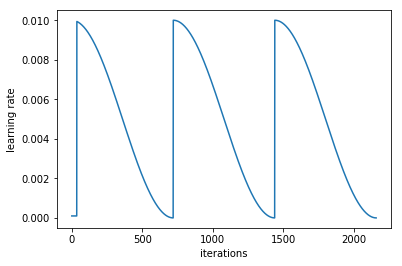

In [49]:
learn.sched.plot_lr()

In [50]:
learn.save('224_lastlayer')

In [51]:
learn.load('224_lastlayer')

### Fine-tuning and differential learning rate annealing

In [52]:
learn.unfreeze()

*using different learning rate for different layers*

In [53]:
lr=np.array([1e-4,1e-3,1e-2])

In [54]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[0.      0.03671 0.02517 0.99121]                             
[1.      0.0406  0.02379 0.99072]                             
[2.      0.03501 0.02312 0.99121]                             
[3.      0.03336 0.02322 0.99219]                             
[4.      0.03848 0.02347 0.99219]                             
[5.      0.03524 0.02408 0.9917 ]                             
[6.      0.0306  0.02396 0.99121]                             



In [55]:
learn.save('224_all')

In [56]:
learn.load('224_all')

In [57]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [61]:
accuracy(probs,y)

0.992

## Analyzing results

In [63]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[993   7]
 [ 11 989]]


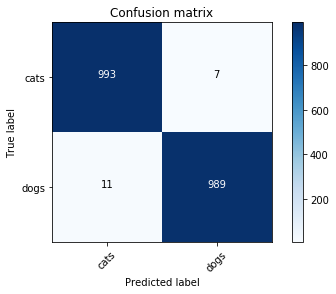

In [64]:
plot_confusion_matrix(cm, data.classes)

### Steps Involved
1. Enable Data Augmentation
2. Use `lr_find()` to find learning rate where loss is still improving 
3. Train last layer from precomputed activations for 1-2 epochs
4. Train last layers with data augmentation for 2-3 epochs with cycle_len=1
5. Unfreeze all layers
6. Set earleir layers to 3x-10x lower learning rate than next higher layer
7. Use `lr_find()` again
8. Train full network with cycle_multi=2 until over-fiting